# TECHNICAL NOTEBOOK

# Using Machine Learning and Natural Language Processing to predict stock price movements from article headlines

## Research question

Can we predict the <b>companies performance on the stockmarket based on the headlines</b> of the news articles?

## Dataset

For this project I retrieved headlines from WSJ online of 6 companies <b>between 2010/01/01 and 2019/11/22</b>, after preprocessing I got <b>??? observations</b>.

For labeling the dataset I used daily stockprices which are available on Yahoo Finance.

The performance was <b>good</b>, if the closed stock price compared to the previous day was 0.5 %point better the S&P500 average. 

The performance was <b>bad</b>, if that stock performance was 0.5 %point worse than the S&P500 average.

## Modeling

The following Machine Learning algorithms was used to make predictions:

- Naive Bayes Model using NLTK library
- Logistic Regression
- K-Nearest Neighbors
- XG Boosting
- Support Vector Machine
- Multinomial Naive Bayes Model
- Bernoulli Naive Bayes Model


## Findings

*
*


In [19]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import pickle
import nltk

## Importing the dataset

In [8]:
train = pd.read_csv('data/train5.csv')
test = pd.read_csv('data/test5.csv')

In [9]:
# create our training data list - this is a list of text of headlines/summaries
train_data = train['tokens']
test_data = test['tokens']

In [10]:
print('Number of train data: ',len(train_data))
print('Number of test data:  ',len(test_data))

Number of train data:  1412
Number of test data:   354


## Vectorizing text features



Tfidf stands for: Term Frequency (times) Inverse Document Frequency. In math notation, Tfidf features are computed as

tf(t, d) \times idf(t) ,

where t is the term (a word in this case), d is the document (a randomly generated string), and tf is a function which counts the number of occurences of t in d. The idf function is computed as

\log{\frac{1+n_{d}}{1+df(d, t)}}+1 ,

where n_{d} is the total number of documents and df(t) is the number of documents that contain t.

A more advanced method is the **TF-IDF vectorizer**. This is an acronym that stands for “Term Frequency – Inverse Document Frequency" which are the components of the resulting scores assigned to each word. This vectorizer result an inverse frequency, the most frequent words get the lowest score.

**Term Frequency:** This summarizes how often a given word appears within a document.

**Inverse Document Frequency:** This downscales words that appear a lot across documents.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer="word",
                                   tokenizer=None,
                                   preprocessor=None,
                                   max_features=5000,
                                   ngram_range=(1, 2))

train_data_features = tfidf_vectorizer.fit_transform(train_data).toarray()
test_data_features = tfidf_vectorizer.transform(test_data).toarray()

# check shapes
print('Shape of train_data: ', train_data_features.shape,
      '\nShape of test_data:  ', test_data_features.shape)

Shape of train_data:  (1412, 5000) 
Shape of test_data:   (354, 5000)


In [12]:
vocab_tfidf = tfidf_vectorizer.get_feature_names()
# tfidf_vectorizer.idf_ #inverse document frequency
tfidf_df = pd.DataFrame(tfidf_vectorizer.idf_, index=vocab_tfidf)

In [13]:
#restructure the target variable
y_train = train.label
y_test = test.label

#check the shapes of target variable
print('Shape of train target: ', y_train.shape,
      '\nShape of test target:  ', y_test.shape)

Shape of train target:  (1412,) 
Shape of test target:   (354,)


In [14]:
y_train.value_counts(normalize=True)

1.0    0.502125
0.0    0.497875
Name: label, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

1.0    0.502825
0.0    0.497175
Name: label, dtype: float64

### Collecting model results

In [16]:
model_score = {}

## Naive Bayes Classifier using NLTK library

### Restructuring dataset for this specific purpose

In [193]:
#using the previously imported dataset
train_pos = np.array(train.loc[train.label==1].tokens)
train_neg = np.array(train.loc[train.label==0].tokens)
test_pos = np.array(test.loc[test.label==1].tokens)
test_neg = np.array(test.loc[test.label==0].tokens)

#create featureset by using Freqency distribution
all_words = []
for doc in train_pos:
    all_words += doc.split(' ')
for doc in train_neg:
    all_words += doc.split(' ')

all_words = nltk.FreqDist(all_words)
word_features = list(all_words.keys())

def find_features(tokens):
    features = {}
    for w in word_features:
        features[w] = (w in tokens)
    return features

#create train features
documents_train = []
for doc in train_pos:
    documents_train.append((doc, 'pos'))
for doc in train_neg:
    documents_train.append((doc, 'neg'))
train_features = [(find_features(text), category) for text, category in documents_train]

#create test features
documents_test = []
for doc in test_pos:
    documents_test.append((doc, 'pos'))
for doc in test_neg:
    documents_test.append((doc, 'neg'))
test_features = [(find_features(text), category) for text, category in documents_test]

### Model fitting

In [194]:
nb_clf = nltk.NaiveBayesClassifier.train(train_features)

nb_train = nltk.classify.accuracy(nb_clf, train_features)
nb_test = nltk.classify.accuracy(nb_clf, test_features)

#collecting results
model_score['Naive Bayes from NLTK'] = {'train': nb_train, 'test': nb_test}

#printing out the result
print(f'Train accuracy score: {nb_train:.3f}')
print(f'Test accuracy score: {nb_test:.3f}')

Train accuracy score: 0.911
Test accuracy score: 0.579


In [ ]:
#save the fitted model
with open('nb_model.sav', 'wb') as file:
    pickle.dump(nb_clf, file)

In [ ]:
# load the model from disk
nb_model = pickle.load(open('nb_model.sav', 'rb'))

In [441]:
# most important features and their likelyhood 
nb_clf.show_most_informative_features(10)

Most Informative Features
             acquisition = True              neg : pos    =      6.4 : 1.0
                    prep = True              pos : neg    =      6.3 : 1.0
                    tack = True              pos : neg    =      5.6 : 1.0
                  weight = True              pos : neg    =      5.6 : 1.0
                 prepare = True              pos : neg    =      5.6 : 1.0
                   doubt = True              neg : pos    =      5.0 : 1.0
                  supply = True              pos : neg    =      5.0 : 1.0
                    soon = True              pos : neg    =      4.6 : 1.0
                 closely = True              neg : pos    =      4.4 : 1.0
                    flat = True              neg : pos    =      4.4 : 1.0


## Logistic Regression 

In [198]:
from sklearn.linear_model import LogisticRegression

# gridsearch original parameters:
params = [{'C': np.logspace(-2, 4, 7),
           'penalty': ['l1', 'l2'],
           'solver': ['lbfgs']
          }]

# gridsearch best parameters:
params = [{'C': [10], 'penalty': ['l1'], 'solver': ['liblinear'] }]

logreg_grid = GridSearchCV(estimator=LogisticRegression(random_state=111),
                           param_grid=params,
                           scoring='accuracy',
                           refit='accuracy',
                           return_train_score = True,
                           cv=5, verbose=2, n_jobs=-1)

#fit the model
logreg_grid.fit(train_data_features, y_train)

#accuracy scores
logreg_train = logreg_grid.best_estimator_.score(train_data_features, y_train)
logreg_test = logreg_grid.best_estimator_.score(test_data_features, y_test)

#collecting
model_score['Logistic regression'] = {'train': logreg_train, 'test': logreg_test}

#printing out the result
print(f'Best parameters: {logreg_grid.best_params_}')
print(f'Train accuracy score: {logreg_train:.3f}')
print(f'Test accuracy score:  {logreg_test:.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Train accuracy score: 0.996
Test accuracy score:  0.568


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished


In [139]:
# pd.DataFrame(logreg_grid.best_estimator_.coef_[0], index=vocab_tfidf).sort_values(by=0)

In [204]:
#save the fitted model
with open('logreg_model.sav', 'wb') as file:
    pickle.dump(logreg_grid.best_estimator_, file)

In [ ]:
# load the model from disk
logreg_model = pickle.load(open('logreg_model.sav', 'rb'))

## Random Forest
Tree based ensemble method. The base idea of the method is the 'bagging', which is short for the bootstrap aggregating. Bootstrap resampling means here, that a subset (sample with replacement) is used for train each tree. The remaining data (Out of bag sample) is used to calculate the out of bag error. This method also uses the 'subspace sampling method', which randomly selects a subset of the features. Each decision tree prediction is aggregated into one estimate.

## K Nearest Neighbors

In [27]:
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors': range(1, 30, 2)}
params = {'n_neighbors': [15]}

knn_grid = GridSearchCV(estimator=KNeighborsClassifier(),
                        param_grid=params,
                        scoring='accuracy',
                        refit='accuracy',
                        return_train_score=True,
                        cv=5, verbose=2, n_jobs=-1)

#fit the model
knn_grid.fit(train_data_features, y_train)

#accuracy scores
knn_train = knn_grid.best_estimator_.score(train_data_features, y_train)
knn_test = knn_grid.best_estimator_.score(test_data_features, y_test)

#collecting results
model_score['KNN'] = {'train': knn_train, 'test': knn_test}

print(f'Best parameters: {knn_grid.best_params_}')
print(f'Train accuracy score: {knn_train:.3f}')
print(f'Test accuracy score:  {knn_test:.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.8s finished


Best parameters: {'n_neighbors': 15}
Train accuracy score: 0.633
Test accuracy score:  0.573


In [206]:
#save the fitted model
with open('knn_model.sav', 'wb') as file:
    pickle.dump(knn_grid.best_estimator_, file)

In [ ]:
# load the model from disk
knn_model = pickle.load(open('knn_model.sav', 'rb'))

## XG Boosting

In [34]:
import xgboost as xgb

params = {'learning_rate': [0.1, 0.15],
          'max_depth': [2, 3, 4, 5, 8],
          'min_child_weight': [0.1, 0.2, 0.3],
          'subsample': [0.2, 0.3, 0.5],
          'n_estimators': [10, 50, 100, 150],
          }

params = {'learning_rate': [0.15],
          'max_depth': [3],
          'reg_alpha': [0.5],
          'subsample': [0.25],
          'n_estimators': [150],
          }

xgboost_grid = GridSearchCV(estimator=xgb.XGBClassifier(random_state=111),
                            param_grid=params,
                            scoring='accuracy',
                            refit='accuracy',
                            return_train_score=True,
                            cv=5, verbose=2, n_jobs=-1)

#fit the model
xgboost_grid.fit(train_data_features, y_train)

#accuracy scores
xgboost_train = xgboost_grid.best_estimator_.score(train_data_features, y_train)
xgboost_test = xgboost_grid.best_estimator_.score(test_data_features, y_test)

#collecting results
model_score['Extreme Gradient Boosting'] = {'train': xgboost_train, 'test': xgboost_test}

#printing out the result
print(f'Best parameters: {xgboost_grid.best_params_}')
print(f'Train accuracy score: {xgboost_train:.3f}')
print(f'Test accuracy score: {xgboost_test:.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.6s finished


Best parameters: {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 150, 'reg_alpha': 0.5, 'subsample': 0.25}
Train accuracy score: 0.739
Test accuracy score: 0.573


In [207]:
#save the fitted model
with open('xgboost_model.sav', 'wb') as file:
    pickle.dump(xgboost_grid.best_estimator_, file)

In [ ]:
#upload the estimator for further use
with open('xgboost_model.sav', 'rb') as file:
    xgboost_model = pickle.load(file)

## Support Vector Machine

In [52]:
from sklearn import svm

params = {'kernel': ['linear', 'poly', 'rbf'],
          'C': [0.1, 1, 10, 1000], #high C allows narrow mistakes
          'degree': [2, 3]}

params = {'kernel': ['linear'], 'C': [10]}

svm_grid = GridSearchCV(estimator=svm.SVC(random_state=111, probability=True),
                        param_grid=params,
                        scoring='accuracy',
                        return_train_score=True,
                        cv=5, verbose=2, n_jobs=-1)

#fit the model
svm_grid.fit(train_data_features, y_train)

#accuracy scores
svm_train = svm_grid.best_estimator_.score(train_data_features, y_train)
svm_test = svm_grid.best_estimator_.score(test_data_features, y_test)

#collecting results
model_score['Support Vector Machine'] = {'train': svm_train, 'test': svm_test}

#printing out the result
print(f'Best parameters: {svm_grid.best_params_}')
print(f'Train accuracy score: {svm_train:.3f}')
print(f'Test accuracy score: {svm_test:.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


Best parameters: {'C': 10, 'kernel': 'linear'}
Train accuracy score: 0.999
Test accuracy score: 0.590


In [371]:
#save the fitted model
with open('svm_model.sav', 'wb') as file:
    pickle.dump(svm_grid.best_estimator_, file)

In [ ]:
with open('svm_model.sav', 'rb') as file:
    svm_model = pickle.load(file)

In [487]:
feat_imp_svm = pd.DataFrame(svm_grid.best_estimator_.coef_[0], index=vocab_tfidf, 
                            columns=['Coefficient'])
feat_imp_svm['Absolute Coefficient'] = feat_imp_svm.Coefficient.apply(lambda x: abs(x))
feat_imp_svm = feat_imp_svm.sort_values(by='Absolute Coefficient', ascending=False)
feat_imp_svm[:10]

,Coefficient,Absolute Coefficient
communication,3.655428,3.655428
live,3.171749,3.171749
bj,2.855259,2.855259
sell volvo,2.810466,2.810466
measure,-2.644216,2.644216
partnership,2.460696,2.460696
industrial business,-2.414116,2.414116
focus,2.401245,2.401245
engineering,-2.394605,2.394605
leader ge,2.375763,2.375763


In [69]:
svm_proba_train = svm_grid.best_estimator_.predict_proba(train_data_features)
svm_proba_test = svm_grid.best_estimator_.predict_proba(test_data_features)

## Multinomial Naive Bayes

posterior = prior * likelyhood / evidence

**posterior:** the probablity that the document is classified as positive (negative), given it contains a word

**prior**: the probability that the document is classified as positive (negative)

**likelyhood:**  probability of the word given the document is classified positive (negative)
 
**evidence:** probability of occurance of the word

In [20]:
from sklearn.naive_bayes import MultinomialNB

params = {'alpha': [1]}

mnb_grid = GridSearchCV(estimator=MultinomialNB(),
                        param_grid=params,
                        scoring='accuracy',
                        return_train_score=True,
                        cv=5, verbose=2, n_jobs=-1)

#fit the model
mnb_grid.fit(train_data_features, y_train)

#accuracy scores
mnb_train = mnb_grid.best_estimator_.score(train_data_features, y_train)
mnb_test = mnb_grid.best_estimator_.score(test_data_features, y_test)

#collecting results
model_score['Naive Bayes'] = {'train': mnb_train, 'test': mnb_test}

#printing out the result
print(f'Best parameters: {mnb_grid.best_params_}')
print(f'Train accuracy score: {mnb_train:.3f}')
print(f'Test accuracy score: {mnb_test:.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best parameters: {'alpha': 1}
Train accuracy score: 0.928
Test accuracy score: 0.596


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


In [24]:
#save the fitted model
with open('mnb_model.sav', 'wb') as file:
    pickle.dump(mnb_grid.best_estimator_, file)

In [25]:
#import the fitted model
with open('mnb_model.sav', 'rb') as file:
    mnb_model = pickle.load(file)

#### feature importance - playground

In [387]:
mnb_grid.best_estimator_.feature_log_prob_[0]

array([-8.51756009, -8.5886076 , -9.01242583, -9.01242583, -8.74501269,
       -6.56833664, -8.17972334, -8.63959061, -8.46727432, -8.82487598,
       -8.67785154, -8.25730963, -8.85446803, -8.81704814, -8.69790613,
       -9.01242583, -8.79365571, -8.39823227, -7.92322152, -9.01242583])

In [486]:
feat_imp_mnb = pd.DataFrame(mnb_grid.best_estimator_.feature_log_prob_[0], index=vocab_tfidf, 
                            columns=['Log_prob'])
# feat_imp_mnb['Absolute_log_prob'] = feat_imp_mnb.Coefficient.apply(lambda x: abs(x))
feat_imp_mnb = feat_imp_mnb.sort_values(by='Log_prob', ascending=False)
# feat_imp_mnb.tail(100)

In [485]:
feat_imp_mnb = pd.DataFrame(mnb_grid.best_estimator_.feature_log_prob_[1], index=vocab_tfidf, 
                            columns=['Log_prob'])
# feat_imp_mnb['Absolute_log_prob'] = feat_imp_mnb.Coefficient.apply(lambda x: abs(x))
feat_imp_mnb = feat_imp_mnb.sort_values(by='Log_prob', ascending=False)
# feat_imp_mnb.tail(100)

In [483]:
neg_class_prob_sorted = mnb_grid.best_estimator_.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = mnb_grid.best_estimator_.feature_log_prob_[1, :].argsort()

# print(np.take(vocab_tfidf, neg_class_prob_sorted[:50]))
# print(np.take(vocab_tfidf, pos_class_prob_sorted[:50]))

In [399]:
important_features= pd.DataFrame(data=np.transpose(mnb_grid.best_estimator_.feature_log_prob_).astype("float32"),
                                 index=vocab_tfidf)

In [484]:
# important_features.sort_values(1).head(50)

## Bernoulli Naive Bayes Classifier

In [350]:
from sklearn.naive_bayes import BernoulliNB

params = {'alpha': [0.9]}

bnb_grid = GridSearchCV(estimator=BernoulliNB(),
                        param_grid=params,
                        scoring='accuracy',
                        return_train_score=True,
                        cv=5, verbose=2, n_jobs=-1)

#fit the model
bnb_grid.fit(train_data_features, y_train)

#accuracy scores
bnb_train = bnb_grid.best_estimator_.score(train_data_features, y_train)
bnb_test = bnb_grid.best_estimator_.score(test_data_features, y_test)

#collecting results
model_score['Bernoulli Naive Bayes'] = {'train': bnb_train, 'test': bnb_test}

#printing out the result
print(f'Best parameters: {bnb_grid.best_params_}')
print(f'Train accuracy score: {bnb_train:.3f}')
print(f'Test accuracy score: {bnb_test:.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best parameters: {'alpha': 0.9}
Train accuracy score: 0.933
Test accuracy score: 0.588


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [351]:
#save the fitted model
with open('bnb_model.sav', 'wb') as file:
    pickle.dump(bnb_grid.best_estimator_, file)

In [ ]:
with open('bnb_model.sav', 'rb') as file:
    bnb_model = pickle.load(file)

## Gaussian Naive Bayes

In [352]:
from sklearn.naive_bayes import GaussianNB

params = [{'alpha':[0.9]}]

gnb_grid = GridSearchCV(estimator=BernoulliNB(),
                        param_grid=params,
                        scoring='accuracy',
                        return_train_score=True,
                        cv=5, verbose=2, n_jobs=-1)

#fit the model
gnb_grid.fit(train_data_features, y_train)

#accuracy scores
gnb_train = gnb_grid.best_estimator_.score(train_data_features, y_train)
gnb_test = gnb_grid.best_estimator_.score(test_data_features, y_test)

#collecting results
model_score['Gaussian Naive Bayes'] = {'train': gnb_train, 'test': gnb_test}

#printing out the result
print(f'Best parameters: {gnb_grid.best_params_}')
print(f'Train accuracy score: {gnb_train:.3f}')
print(f'Test accuracy score: {gnb_test:.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best parameters: {'alpha': 0.9}
Train accuracy score: 0.933
Test accuracy score: 0.588


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [353]:
#save the fitted model
with open('gnb_model.sav', 'wb') as file:
    pickle.dump(gnb_grid.best_estimator_, file)

In [ ]:
with open('gnb_model.sav', 'rb') as file:
    gnb_model = pickle.load(file)

## Model selection

In [354]:
results = pd.DataFrame(model_score).T.applymap(lambda x: round(x,3))
results[['train', 'test']]

,train,test
Logistic regression,0.996,0.568
Random forest,0.839,0.559
KNN,0.633,0.573
Support Vector Machine,0.999,0.590
Extreme Gradient Boosting,0.739,0.573
Naive Bayes,0.928,0.596
Naive Bayes from NLTK,0.911,0.579
Bernoulli Naive Bayes,0.933,0.588
Gaussian Naive Bayes,0.933,0.588


## Confusion matrix

In [99]:
from sklearn.metrics import confusion_matrix
# svm
cnf_matrix = confusion_matrix(y_test, svm_grid.predict(test_data_features))
cnf_matrix

array([[103,  73],
       [ 72, 106]])

In [299]:
# naiv bayes
cnf_matrix = confusion_matrix(y_test, nb_grid.predict(test_data_features))
cnf_matrix

array([[113,  63],
       [ 83,  95]])

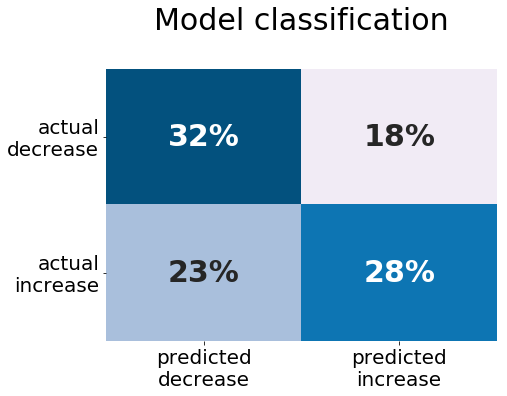

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(y_test, features, model, palname):
    '''
    This function plots a confusion matrix for the specified model and drug.
    Parameters
    ----------
        y_test: DataFrame or series, test set of target values
        features: DataFrame or series, test set of features
        model: model (best estimator) used
        palname: seaborn palette name
    Returns
    -------
    Confusion Matrix showing the percentages for each TP, FP, TN, FN
    '''
#     matrix = confusion_matrix(y_test, model.best_estimator_.predict(features))
    matrix = confusion_matrix(y_test, model.predict(features))
    matrix = matrix / matrix.astype(np.float).sum()
    df_matrix = pd.DataFrame(matrix,
                             columns=['predicted\ndecrease', 'predicted\nincrease'],
                             index=['actual\ndecrease', 'actual\nincrease'])
    plt.figure(figsize=(7, 5))
    col = sns.color_palette(palname, 10)
    sns.heatmap(df_matrix, annot=True,
                fmt='.0%', cmap=col, cbar=False,
                annot_kws={"size": 30, 'weight':'bold', 
                           'fontname':'AppleGothic'})
    plt.title(f'Model classification\n', fontsize=30)
    plt.yticks(rotation=0, fontsize=20)
    plt.xticks(fontsize=20)
    
plot_confusion_matrix(y_test, test_data_features, mnb_model, 'PuBu')


### Visualize feature importance based on Naive Bayes Classifier

In [489]:
from io import StringIO
import sys
from contextlib import redirect_stdout

print_features = StringIO()
with redirect_stdout(print_features):
    nb_clf.show_most_informative_features(200)


In [490]:
import re

words = re.findall(r'([a-z]+).=', print_features.getvalue())
cat = re.findall(r'([a-z]+).:', print_features.getvalue())
likelyhood = re.findall(r'([0-9].[0-9]).:',print_features.getvalue())

important_features = pd.DataFrame([words,cat,likelyhood]).T
important_features.columns = ['word', 'cat', 'likelyhood']
important_features.likelyhood = important_features.likelyhood.astype(float)
important_features.head()

,word,cat,likelyhood
0,acquisition,neg,6.4
1,prep,pos,6.3
2,tack,pos,5.6
3,weight,pos,5.6
4,prepare,pos,5.6


In [ ]:
neg_words = {row['word']:row['likelyhood'] for i, row in 
             important_features.loc[important_features.cat=='neg'].iterrows()}
pos_words = {row['word']:row['likelyhood'] for i, row in 
             important_features.loc[important_features.cat=='pos'].iterrows()}

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.update(['Mr.', 'Mrs.', 'Ford', 'Tesla', 'Boeing', 'Microsoft', 'Goldman', 'Sachs',
                  'GE','General', 'Electric', 'tack', 'prep'])

def plot_wordcloud(text_freq_dict):
    '''
    Generates wordcloud plot from text frequency distribution
    ---------
    Inputs:
        text_freq_dict: dictionary of text (string) and it's frequency (float)
    ---------
    Output:
        wordcloud plot, but no return value
    '''
    plt.figure(figsize=(8,6))
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap='tab10',
                          max_words=50, width= 400, height=300)
    wordcloud.generate_from_frequencies(text_freq_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#colormaps: 'tab10'

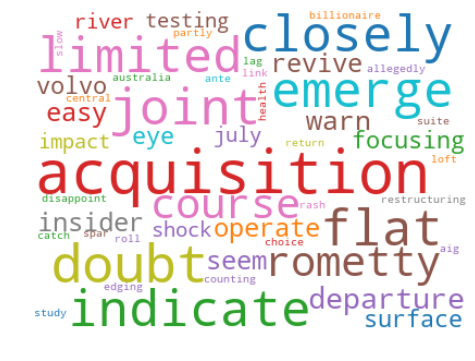

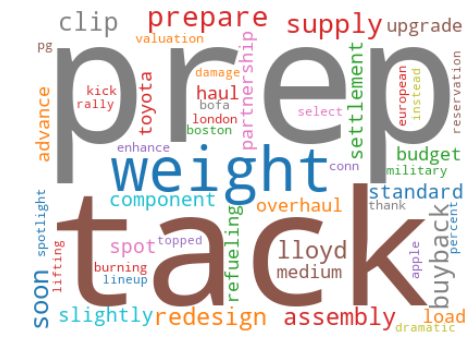

In [491]:
plot_wordcloud(neg_words)
plot_wordcloud(pos_words)

## JUST PLAYING AROUND

In [67]:
train_mod = train
test_mod = test

In [70]:
train_mod['proba'] = svm_proba_train[:, 1]
test_mod['proba'] = svm_proba_test[:,1]

In [211]:
test_mod.tail()

,Unnamed: 0,date,text,topic,tokens,change,nextday,change_i,nextday_i,volume_ratio,label,proba
349,964,2010-07-16,Goldman Settles Its Battle With SEC Goldman Sa...,BUSINESS,goldman settle battle sec goldman sachs agree ...,0.6542,-0.3352,-2.8819,0.5982,2.72,1.0,0.524643
350,376,2019-07-12,VW Ups Its Investment in Ford’s Self-Driving C...,AUTOS,vw ups investment ford self drive car unit vol...,2.9441,-0.6673,0.4620,0.0176,1.34,1.0,0.482361
351,679,2016-01-20,"IBM Revenue Slides, but Cloud Business Grows I...",TECH,ibm revenue slide cloud business grow ibm say ...,-4.8786,0.8616,-1.1694,0.5195,2.59,0.0,0.470080
352,600,2010-10-06,Geely Wants to Sell Chinese Cars In Europe Gee...,AUTOS - INDUSTRY,geely want sell chinese car europe geely chine...,1.7679,0.6042,-0.0672,-0.1647,1.62,1.0,0.486540
353,780,2017-01-31,Goldman’s Blankfein Gives a Wall Street Voice ...,MARKETS,goldman blankfein give wall street voice immig...,-1.9581,0.5887,-0.0890,0.0298,1.14,0.0,0.553010


In [5]:
from nltk.sentiment.sentiment_analyzer import SentimentAnalyzer


In [6]:
senti = SentimentAnalyzer()
senti.train(NaiveBayesClassifier.train, train_features)
senti(test_features)

NameError: name 'NaiveBayesClassifier' is not defined

In [4]:
?senti.train()

Object `senti.train()` not found.
